#### Necessary libraries and functions

In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)
    R2 = r2_score(y, predictions)

    print('MAE for', model_name, ': %1.3f' % MAE)
    print('MAPE for', model_name, ': %1.3f' % MAPE)
    print('RMSE for', model_name, ': %1.3f' % RMSE)
    print('R2 for', model_name, ': %1.3f' % R2)
    
    
def plot_predictions(model, x, y, title):
    
    plt.figure(figsize = (7, 4))
    sns.scatterplot(x = y, y = model.predict(x), s = 20)
    sns.lineplot([0, 18000], [0, 18000], color = 'black', linewidth = 1)
    plt.title(title + '\n')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

#### Data we'll be working with

In [150]:
data = pd.read_csv('../data/diamonds_cleaned.csv')
data.head()

carat      cut color clarity  depth  table  price
0   0.23    Ideal     E     SI2   61.5   55.0    326
1   0.21  Premium     E     SI1   59.8   61.0    326
2   0.23     Good     E     VS1   56.9   65.0    327
3   0.29  Premium     I     VS2   62.4   58.0    334
4   0.31     Good     J     SI2   63.3   58.0    335

In [151]:
data = data.sample(10000, random_state = 20202020)

#### Usual train test split

In [152]:
X = data.drop('price', 1).copy()
y = data['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 20202020)

In [156]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#### Applying a dummy regressor and a linear regression to see how much a sophisticated ML algo can bring us closer to the truth

For non-CatBoost models we need to deal with categoricals. We can label or one-hot encode them, I'll use one-hot encoding

In [157]:
X_train_encoded = pd.get_dummies(X_train, columns = ['cut', 'color', 'clarity'], prefix_sep = ' = ')
X_test_encoded = pd.get_dummies(X_test, columns = ['cut', 'color', 'clarity'], prefix_sep = ' = ')

print('Original data has %g columns' % X_train.shape[1])
print('One hot encoded data has %g columns' % X_train_encoded.shape[1])

X_train_encoded.head()

Original data has 6 columns
One hot encoded data has 23 columns


carat  depth  table  cut = Fair  cut = Good  cut = Ideal  cut = Premium  \
0   1.26   59.9   59.0           0           0            0              0   
1   0.27   62.2   55.0           0           0            1              0   
2   0.55   61.2   56.0           0           0            1              0   
3   0.36   61.4   56.0           0           0            1              0   
4   0.33   61.5   59.0           0           0            0              1   

   cut = Very Good  color = D  color = E  ...  color = I  color = J  \
0                1          1          0  ...          0          0   
1                0          0          1  ...          0          0   
2                0          0          0  ...          0          0   
3                0          0          0  ...          0          0   
4                0          0          1  ...          0          0   

   clarity = I1  clarity = IF  clarity = SI1  clarity = SI2  clarity = VS1  \
0             0             0              1              0              0   
1             0             0              0              0              0   
2             0             0              0              1              0   
3             0             0              1              0              0   
4             0             0              0              0              0   

   clarity = VS2  clarity = VVS1  clarity = VVS2  
0              0               0               0  
1              0               0               1  
2              0               0               0  
3              0               0               0  
4              1               0               0  

[5 rows x 23 columns]

Now applying the dummy

In [158]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(X_train_encoded, y_train)

evaluate_model('Dummy regressor', dummy, X_test_encoded, y_test)

MAE for Dummy regressor : 3060.995
MAPE for Dummy regressor : 191.058
RMSE for Dummy regressor : 4000.940
R2 for Dummy regressor : -0.000


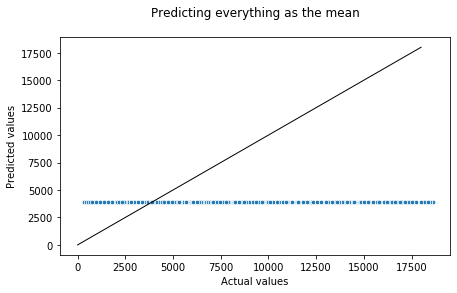

In [159]:
plot_predictions(dummy, X_test_encoded, y_test, 'Predicting everything as the mean')

Now applying a simple linear regression

In [160]:
linreg = LinearRegression()
linreg.fit(X_train_encoded, y_train)

evaluate_model('Linear regression', linreg, X_test_encoded, y_test)

MAE for Linear regression : 811.631
MAPE for Linear regression : 46.491
RMSE for Linear regression : 1151.128
R2 for Linear regression : 0.917


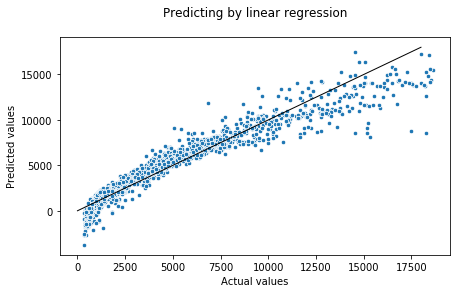

In [161]:
plot_predictions(linreg, X_test_encoded, y_test, 'Predicting by linear regression')

# Welcome to CatBoost

<img src="https://camo.githubusercontent.com/978ad57e1fba31f89403bdc139b9dbaffe70d32e88e31e4017897d902955dcad/687474703a2f2f73746f726167652e6d64732e79616e6465782e6e65742f6765742d646576746f6f6c732d6f70656e736f757263652f3235303835342f636174626f6f73742d6c6f676f2e706e67" style="width: 300px;"/>

- Open sourced by Yandex (Google of Russia)
- Product of 2017 (right away competitor of xgBoost and LightGBM)

Main advantages
1. Handling of categorical data without one-hot encoding
2. Great performance with default parameters
3. Model monitoring (live plots like in DL)
4. Overfit detection (~ early stop like in DL)
5. Snapshotting (in case of crashing no need to start from scratch)

Boosting-specific advantages
1. Multiple tree building methods (depthwise, leafwise, symmetric trees)
2. Eval metric vs custom metric vs loss function
3. Built in feature and object importances, feature interactions, feature analysis and SHAP values
4. Remaining time calculator
5. Evaluation timer (no need to calculate i.e. AUC after every round as it is expensive)

In [162]:
from catboost import CatBoostRegressor

## 1. Simple, default model, no tuning, no cross-validation

In [163]:
default_model = CatBoostRegressor(random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 100)
default_model.fit(X_train, y_train)

Learning rate set to 0.056513
0:	learn: 3789.1237160	total: 29.3ms	remaining: 29.2s
100:	learn: 619.1348179	total: 2.72s	remaining: 24.2s
200:	learn: 544.8981097	total: 5.16s	remaining: 20.5s
300:	learn: 515.5362722	total: 7.6s	remaining: 17.6s
400:	learn: 496.7017591	total: 10.1s	remaining: 15s
500:	learn: 479.6363025	total: 12.5s	remaining: 12.5s
600:	learn: 463.1024027	total: 15.1s	remaining: 10s
700:	learn: 448.7739633	total: 17.8s	remaining: 7.6s
800:	learn: 436.3084421	total: 20.3s	remaining: 5.04s
900:	learn: 425.8952836	total: 22.8s	remaining: 2.5s
999:	learn: 415.6422161	total: 25.5s	remaining: 0us


In [164]:
evaluate_model('CatBoost default', default_model, X_test, y_test)

MAE for CatBoost default : 299.395
MAPE for CatBoost default : 8.582
RMSE for CatBoost default : 567.975
R2 for CatBoost default : 0.980


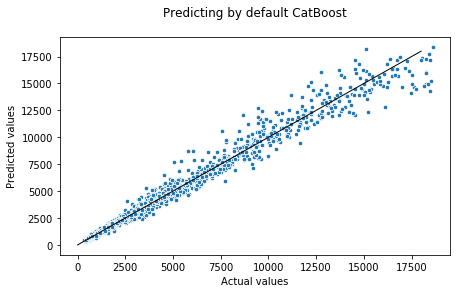

In [165]:
plot_predictions(default_model, X_test, y_test, 'Predicting by default CatBoost')

### 1.1. What was the best score on the train set?

In [166]:
default_model.best_score_

{'learn': {'RMSE': 415.64221605744456}}

CatBoost calculates RMSE **by default for regression**, however you can (1) calculate and (2) monitor whatever you want to

- Supported metrics: https://catboost.ai/docs/references/custom-metric__supported-metrics.html
- Regression specific: https://catboost.ai/docs/concepts/loss-functions-regression.html
- Classification specific: https://catboost.ai/docs/concepts/loss-functions-classification.html


#### Let's optimize still for RMSE, but monitor MAPE

In [167]:
model = CatBoostRegressor(random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 100,
                          eval_metric = 'MAPE')
model.fit(X_train, y_train)

Learning rate set to 0.056513
0:	learn: 1.7846999	total: 26.9ms	remaining: 26.9s
100:	learn: 0.1138800	total: 2.8s	remaining: 24.9s
200:	learn: 0.0943137	total: 5.9s	remaining: 23.5s
300:	learn: 0.0901259	total: 8.83s	remaining: 20.5s
400:	learn: 0.0881185	total: 12.2s	remaining: 18.3s
500:	learn: 0.0863460	total: 14.8s	remaining: 14.8s
600:	learn: 0.0839929	total: 17.9s	remaining: 11.9s
700:	learn: 0.0822674	total: 20.9s	remaining: 8.92s
800:	learn: 0.0808452	total: 24.2s	remaining: 6s
900:	learn: 0.0795899	total: 27.1s	remaining: 2.98s
999:	learn: 0.0785144	total: 29.9s	remaining: 0us


In [168]:
model.best_score_

{'learn': {'MAPE': 0.07851444342820475, 'RMSE': 415.64221605744456}}

#### Let's optimize for MAE and keep an eye on RMSE, R2 and MAPE

In [169]:
model = CatBoostRegressor(random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 100,
                          objective = 'MAE', # eval_metric = 'MAE' because eval metric automatically matches loss function
                          custom_metric = ['RMSE', 'R2', 'MAPE'])
model.fit(X_train, y_train)

0:	learn: 2738.4572492	total: 38.8ms	remaining: 38.7s
100:	learn: 527.1603055	total: 3.3s	remaining: 29.4s
200:	learn: 356.9776718	total: 6.09s	remaining: 24.2s
300:	learn: 314.3406332	total: 8.87s	remaining: 20.6s
400:	learn: 291.9202538	total: 11.9s	remaining: 17.7s
500:	learn: 281.7875385	total: 14.7s	remaining: 14.7s
600:	learn: 273.9517451	total: 17.8s	remaining: 11.8s
700:	learn: 268.6886317	total: 21.3s	remaining: 9.1s
800:	learn: 264.9229931	total: 23.9s	remaining: 5.94s
900:	learn: 261.1090855	total: 26.8s	remaining: 2.95s
999:	learn: 258.2777959	total: 29.9s	remaining: 0us


In [170]:
model.best_score_

{'learn': {'MAPE': 0.07045940080366724,
  'MAE': 258.2777959376879,
  'R2': 0.9831483871142839,
  'RMSE': 515.5857605205113}}

In [171]:
evaluate_model('CatBoost optimizing MAE', model, X_test, y_test)

MAE for CatBoost optimizing MAE : 301.129
MAPE for CatBoost optimizing MAE : 7.889
RMSE for CatBoost optimizing MAE : 593.651
R2 for CatBoost optimizing MAE : 0.978


### 1.2. Reading the training history is great but let's *see* what's happening during training

In [172]:
model = CatBoostRegressor(random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 100, 
                          custom_metric = ['MAE', 'MAPE', 'R2'])

model.fit(X_train, y_train, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### The interesting stuff happens until the 100th tree, so let's just build 100 and visualize the training

CatBoost sets the learning rate relative to how many trees we're building and how many features we have. Let's use the same learning rate from before, so we get the same learning slope

In [173]:
print('Previously this was the automatic eta:', model.learning_rate_)

lr = model.learning_rate_

Previously this was the automatic eta: 0.05651300027966499


In [174]:
model = CatBoostRegressor(num_trees = 100,
                          learning_rate = lr,
                          random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 200, 
                          custom_metric = ['MAE', 'MAPE', 'R2'])

model.fit(X_train, y_train, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Plateauing starts near the 80th tree, but is our test error still decreasing? Let's check! 

We'll add our test set as the validation data to the CatBoost regressor and see how the model performs on new data

In [175]:
model = CatBoostRegressor(num_trees = 100,
                          learning_rate = lr,
                          random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          verbose = 200, 
                          custom_metric = ['MAE', 'MAPE', 'R2'])

model.fit(X_train, y_train, eval_set = (X_test, y_test),
          plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Okay, we're not overfitting, there's just less and less to learn

#### Let's overfit a little

In [176]:
model = CatBoostRegressor(num_trees = 100,
                          learning_rate = 0.75,
                          random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          custom_metric = ['MAE', 'MAPE', 'R2'])

model.fit(X_train, y_train, eval_set = (X_test, y_test), plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Setting the learning rate too high will  disallow the optimization function to get closer to the global minima. After the 69th tree, out test error started increasing. How cool is that? We know after which iteration we've started overfitting.

In [177]:
print('Based on test error, you should only build %g trees' % (model.best_iteration_ + 1))

Based on test error, you should only build 69 trees


#### Bonus feature, plot two models on the same chart, compare their training history visually

In [178]:
from catboost import MetricVisualizer

In [179]:
large_lr_model = CatBoostRegressor(num_trees = 100,
                                   learning_rate = 0.8,
                                   random_state = 20202020, 
                                   cat_features = ['cut', 'color', 'clarity'],
                                   custom_metric = ['MAE', 'MAPE', 'R2'],
                                   train_dir = 'learing_rate_0.8')

small_lr_model = CatBoostRegressor(num_trees = 100,
                                   learning_rate = 0.05,
                                   random_state = 20202020, 
                                   cat_features = ['cut', 'color', 'clarity'],
                                   custom_metric = ['MAE', 'MAPE', 'R2'],
                                   train_dir = 'learing_rate_0.05')

large_lr_model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 20)
small_lr_model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 20)

0:	learn: 1724.2079598	test: 1771.1365519	best: 1771.1365519 (0)	total: 25.1ms	remaining: 2.48s
20:	learn: 573.4246549	test: 659.0718803	best: 659.0718803 (20)	total: 546ms	remaining: 2.05s
40:	learn: 505.3923482	test: 633.0471743	best: 632.4641618 (31)	total: 994ms	remaining: 1.43s
60:	learn: 465.0112769	test: 623.1156790	best: 622.5500255 (53)	total: 1.44s	remaining: 919ms
80:	learn: 438.6897313	test: 622.0166175	best: 621.8381477 (79)	total: 1.87s	remaining: 439ms
99:	learn: 415.2620739	test: 622.2782245	best: 621.8381477 (79)	total: 2.29s	remaining: 0us

bestTest = 621.8381477
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 3805.1027565	test: 3835.9629093	best: 3835.9629093 (0)	total: 19.2ms	remaining: 1.9s
20:	learn: 1936.9557241	test: 1985.3123380	best: 1985.3123380 (20)	total: 450ms	remaining: 1.69s
40:	learn: 1336.5755047	test: 1391.6384414	best: 1391.6384414 (40)	total: 884ms	remaining: 1.27s
60:	learn: 963.6817778	test: 1009.8351446	best: 1009.8351446 (60)	

In [180]:
MetricVisualizer(['learing_rate_0.8', 'learing_rate_0.05']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Why build our ensemble after we've already reached our best test error?

In [181]:
model = CatBoostRegressor(num_trees = 100,
                          learning_rate = 0.75,
                          random_state = 20202020, 
                          cat_features = ['cut', 'color', 'clarity'],
                          custom_metric = ['MAE', 'MAPE', 'R2'], 
                          early_stopping_rounds = 5)

model.fit(X_train, y_train, eval_set = (X_test, y_test), plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [182]:
print('Reached your best test error at tree #%g' % (model.best_iteration_ + 1))

Reached your best test error at tree #46


In [183]:
model.tree_count_ == model.best_iteration_ + 1 == 46

True

## 2. Tuning hyperparameters and using cross-validation

We'll use 3-fold CV, leveraging CatBoost's built in functions (no sklearn GridSearchCV)

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" style="width: 500px;"/>


In [49]:
# Let's check the defult model's parameters

# default_model.get_all_params()

In [62]:
grid = {'learning_rate' : [0.0565, 0.03],
        'l2_leaf_reg' : [1], 
        'rsm' : [3/4],
        'depth' : [6, 8], 
        'iterations' : [750],
        'one_hot_max_size' : [2, 10]}

model = CatBoostRegressor(random_state = 20202020,
                          cat_features = ['cut', 'color', 'clarity'],
                          custom_metric = ['MAE', 'MAPE', 'R2'])

grid_search_results = model.grid_search(grid, X_train, y_train, cv = 3, search_by_train_test_split = False,
                                        partition_random_seed = 20202020, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 563.3141116	best: 563.3141116 (0)	total: 1m 57s	remaining: 13m 39s
1:	loss: 593.0731396	best: 563.3141116 (0)	total: 2m 52s	remaining: 8m 36s
2:	loss: 570.8233708	best: 563.3141116 (0)	total: 4m 58s	remaining: 8m 17s
3:	loss: 597.3013543	best: 563.3141116 (0)	total: 6m 12s	remaining: 6m 12s
4:	loss: 584.1726726	best: 563.3141116 (0)	total: 8m 25s	remaining: 5m 3s
5:	loss: 594.0201292	best: 563.3141116 (0)	total: 9m 21s	remaining: 3m 7s
6:	loss: 578.8797595	best: 563.3141116 (0)	total: 11m 29s	remaining: 1m 38s
7:	loss: 592.9830886	best: 563.3141116 (0)	total: 12m 37s	remaining: 0us


It took 15 mins to go over the grid and optimize hyperparameters, so let's save the model for later

In [63]:
model.save_model(fname = 'tuned_model', format = 'cbm')

In [184]:
model = CatBoostRegressor(cat_features = ['cut', 'color', 'clarity'],
                          custom_metric = ['MAE', 'MAPE', 'R2'])

model.load_model('tuned_model', format = 'cbm')

model.fit(X_train, y_train)

Check the best params

In [64]:
grid_search_results['params']

{'depth': 6,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 1,
 'iterations': 750,
 'rsm': 0.75,
 'learning_rate': 0.0565}

In [65]:
pd.DataFrame(grid_search_results['cv_results']).tail()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
745         745      563.264789       8.791674       392.232487   
746         746      563.307695       8.870081       392.091775   
747         747      563.339113       8.769907       391.910036   
748         748      563.292201       8.724794       391.823246   
749         749      563.314112       8.718334       391.757714   

     train-RMSE-std  test-MAE-mean  test-MAE-std  train-MAE-mean  \
745       11.126053     296.419429      1.217490      233.466009   
746       11.136183     296.447043      1.185149      233.383337   
747       11.114639     296.449573      1.205705      233.309111   
748       11.052704     296.432702      1.250664      233.272376   
749       11.026498     296.439921      1.269888      233.228340   

     train-MAE-std  test-MAPE-mean  test-MAPE-std  train-MAPE-mean  \
745       4.270780        0.086988       0.000864         0.077941   
746       4.280923        0.086996       0.000861         0.077928   
747       4.279110        0.086991       0.000843         0.077918   
748       4.256550        0.086989       0.000832         0.077917   
749       4.240806        0.086993       0.000830         0.077904   

     train-MAPE-std  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  
745        0.000691      0.979886     0.000210       0.990243      0.000509  
746        0.000710      0.979883     0.000217       0.990250      0.000509  
747        0.000708      0.979881     0.000210       0.990259      0.000507  
748        0.000701      0.979884     0.000207       0.990263      0.000505  
749        0.000695      0.979882     0.000206       0.990267      0.000503

In [185]:
print('Default model\n')
evaluate_model('CatBoost default', default_model, X_test, y_test)
print('\nTuned  model\n')
evaluate_model('CatBoost tuned', model, X_test, y_test)

Default model

MAE for CatBoost default : 299.395
MAPE for CatBoost default : 8.582
RMSE for CatBoost default : 567.975
R2 for CatBoost default : 0.980

Tuned  model

MAE for CatBoost tuned : 295.557
MAPE for CatBoost tuned : 8.438
RMSE for CatBoost tuned : 561.006
R2 for CatBoost tuned : 0.980


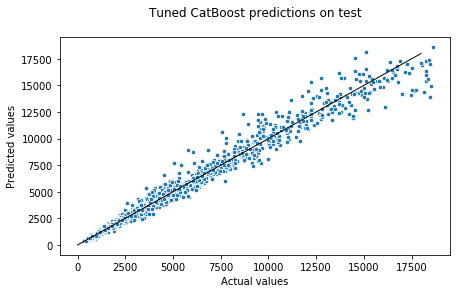

In [186]:
plot_predictions(model, X_test, y_test, 'Tuned CatBoost predictions on test')

## 3. Model evaluation, explanation

CatBoost is a trees ensemble, therefore a blackbox model. We need to know why certain predictions happen, how the features impact the predictions. We can

1. Visualize some trees
2. Calculate feature importances when building trees and making splits
3. Calculate SHAP values to determine effect of features on given predictions
4. Find most important datapoints that drive decision making

<img src="https://miro.medium.com/max/875/1*2g4vm8lWZTLpEqbIFNQ4wg.png" style="width: 300px;"/>


In [187]:
from catboost import Pool

### 3.1. Tree visualization

### 3.2. Visualize metrics and feature statistics

#### 3.2.1. Eval metrics

Create a CatBoost Pool object. This is basically a dataset + metadata container. It keeps track of what is the X, what is the y, what are the categorical features and what are the names of all the features. It can be supplied to any CatBoost function, and then there's no need to separately mark X, y, etc...

In [188]:
test_pool = Pool(X_test, y_test, 
                 cat_features = ['cut', 'color', 'clarity'], 
                 feature_names = list(X_test.columns))

In [189]:
model.eval_metrics(test_pool, ['RMSE', 'MAE', 'MAPE', 'R2'], plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'RMSE': [3822.5427202477217,
  3646.9736615074157,
  3485.5494262241864,
  3332.418834552187,
  3192.1084646500567,
  3058.829229677594,
  2937.6533541288463,
  2825.611470219394,
  2717.705125022903,
  2617.0453075776327,
  2505.4679475369626,
  2395.488692541813,
  2306.692916598551,
  2212.807053958945,
  2128.6424673266374,
  2055.3776380818376,
  1977.7362422819886,
  1897.789699007438,
  1822.3985404214366,
  1762.9416953872492,
  1702.2370568291271,
  1639.6921299479977,
  1590.6705281608115,
  1536.9570565287506,
  1490.9144617476688,
  1438.5652882813063,
  1395.451108043267,
  1356.1119147487143,
  1317.5668969114513,
  1283.871906325984,
  1254.5970987477222,
  1220.3202169339088,
  1190.3268883962774,
  1158.0914702440737,
  1130.4604229630668,
  1107.0766730091555,
  1092.3397466683568,
  1069.218403404058,
  1050.2159504787678,
  1028.546318957281,
  1011.3069685453693,
  995.5504798088872,
  976.5510721545992,
  965.5721462785189,
  951.5880438654135,
  939.988794156240

#### 3.2.2. Feature statistics

In [190]:
model.calc_feature_statistics(X_train, y_train, 'carat')

{'borders': array([0.235     , 0.245     , 0.255     , 0.265     , 0.275     ,
        0.285     , 0.29500002, 0.305     , 0.315     , 0.325     ,
        0.335     , 0.345     , 0.365     , 0.375     , 0.385     ,
        0.39499998, 0.405     , 0.425     , 0.435     , 0.445     ,
        0.45499998, 0.465     , 0.475     , 0.485     , 0.495     ,
        0.505     , 0.525     , 0.53499997, 0.555     , 0.575     ,
        0.585     , 0.595     , 0.605     , 0.615     , 0.635     ,
        0.645     , 0.675     , 0.685     , 0.695     , 0.705     ,
        0.71500003, 0.725     , 0.735     , 0.745     , 0.755     ,
        0.765     , 0.78499997, 0.795     , 0.805     , 0.815     ,
        0.825     , 0.835     , 0.845     , 0.855     , 0.865     ,
        0.875     , 0.885     , 0.895     , 0.905     , 0.915     ,
        0.925     , 0.935     , 0.945     , 0.955     , 0.96500003,
        0.975     , 0.985     , 0.995     , 1.005     , 1.015     ,
        1.025     , 1.035     , 1.045

In [191]:
model.calc_feature_statistics(X_train, y_train, 'depth')

{'borders': array([57.65    , 57.75    , 57.95    , 58.05    , 58.15    , 58.25    ,
        58.55    , 58.65    , 58.85    , 58.95    , 59.05    , 59.15    ,
        59.75    , 59.85    , 60.05    , 60.15    , 60.25    , 60.45    ,
        60.55    , 60.65    , 60.75    , 60.85    , 60.95    , 61.05    ,
        61.25    , 61.35    , 61.45    , 61.55    , 61.65    , 61.75    ,
        61.85    , 61.95    , 62.05    , 62.15    , 62.25    , 62.35    ,
        62.45    , 62.55    , 62.65    , 62.75    , 62.85    , 62.95    ,
        63.05    , 63.15    , 63.25    , 63.35    , 63.45    , 63.55    ,
        63.65    , 63.75    , 63.85    , 63.95    , 64.05    , 64.149994,
        64.25    , 64.45    , 64.75    , 64.850006, 64.95    , 65.05    ,
        65.149994, 65.25    , 65.55    , 65.649994, 65.75    , 66.149994,
        66.75    , 67.05    , 67.6     , 67.95    , 68.2     ],
       dtype=float32),
 'binarized_feature': array([14, 34, 24, ..., 27, 31, 15]),
 'mean_target': array([4095.

You can see the bins for categorical features as well, but **only** if all of their values have been one hot encoded. For this, upon training, set the **one_hot_max_size** parameter to a higher value

In [192]:
default_model_ = CatBoostRegressor(random_state = 20202020, 
                                   cat_features = ['cut', 'color', 'clarity'],
                                   verbose = 100, one_hot_max_size = 10)
default_model_.fit(X_train, y_train)

Learning rate set to 0.056513
0:	learn: 3788.2055964	total: 3.56ms	remaining: 3.55s
100:	learn: 689.3906181	total: 509ms	remaining: 4.53s
200:	learn: 557.8922371	total: 982ms	remaining: 3.9s
300:	learn: 510.5133115	total: 1.48s	remaining: 3.44s
400:	learn: 480.6793672	total: 1.92s	remaining: 2.86s
500:	learn: 458.9598855	total: 2.33s	remaining: 2.32s
600:	learn: 440.5650157	total: 2.81s	remaining: 1.87s
700:	learn: 423.5838876	total: 3.23s	remaining: 1.38s
800:	learn: 410.9997550	total: 3.65s	remaining: 908ms
900:	learn: 400.3803083	total: 4.17s	remaining: 458ms
999:	learn: 391.8399099	total: 4.6s	remaining: 0us


In [193]:
default_model_.calc_feature_statistics(X_train, y_train, 'cut')

{'binarized_feature': array([4, 3, 3, ..., 3, 3, 0]),
 'mean_target': array([4569.1313, 4065.3176, 3755.    , 3565.814 , 3905.0876],
       dtype=float32),
 'mean_weighted_target': array([], dtype=float32),
 'mean_prediction': array([4569.661 , 4064.9297, 3754.325 , 3565.3186, 3906.1267],
       dtype=float32),
 'objects_per_bin': array([2048,  211,  726, 3214, 1801], dtype=uint32),
 'predictions_on_varying_feature': array([3891.27544548, 3796.950036  , 3831.21513364, 4062.75210936,
        3903.02848512]),
 'cat_values': array(['Premium', 'Fair', 'Good', 'Ideal', 'Very Good'], dtype='<U9')}

### 3.3. Feature importances

In [194]:
train_pool = Pool(X_train, y_train, 
                  cat_features = ['cut', 'color', 'clarity'], 
                  feature_names = list(X_test.columns))

#### 3.3.1. Simple feature importances

1. PredictionValuesChange - how much on average the prediction changes if the feature value changes
2. LossFunctionChange - difference between the loss function obtained using the model in normal scenario (when we include the feature) and model without this feature (model is built approximately using the original model with this feature removed from all the trees in the ensemble). Higher the difference, the more important the feature is

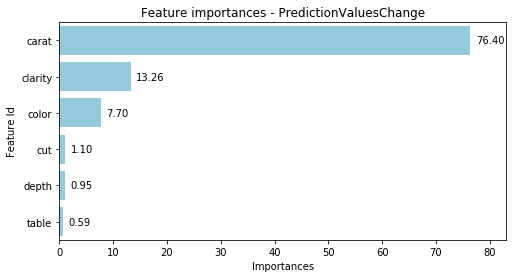

In [195]:
PredictionValuesChange = model.get_feature_importance(train_pool, type = 'PredictionValuesChange', prettified = True)

fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot(x = 'Importances', y = 'Feature Id', data = PredictionValuesChange, color = 'skyblue', ax = ax)
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 1, p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), ha = 'left', va = 'center', size = 10) 
plt.xlim(0, 83)
plt.title('Feature importances - PredictionValuesChange')
plt.show()

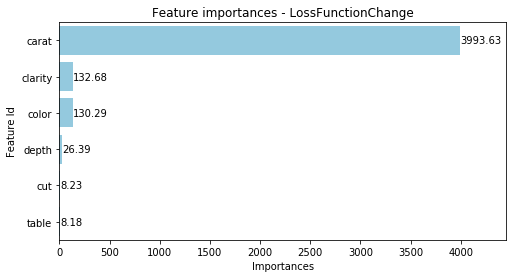

In [196]:
LossFunctionChange = model.get_feature_importance(train_pool, type = 'LossFunctionChange', prettified = True)

fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot(x = 'Importances', y = 'Feature Id', data = LossFunctionChange, color = 'skyblue', ax = ax)
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 1, p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), ha = 'left', va = 'center', size = 10) 
plt.xlim(0, 4450)
plt.title('Feature importances - LossFunctionChange')
plt.show()

#### 3.3.2. SHAP values

In [197]:
import shap
shap.initjs()

In [198]:
shap_values = model.get_feature_importance(train_pool, type = 'ShapValues')

In [199]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [200]:
print(shap_values.shape)
print(X_train.shape)

(8000, 6)
(8000, 6)


Plot a couple of predictions

In [201]:
print('Predicted value:', model.predict(X_train)[0])
print('Actual value:', y_train.iloc[0])

Predicted value: 7969.4349271265855
Actual value: 7785


In [202]:
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

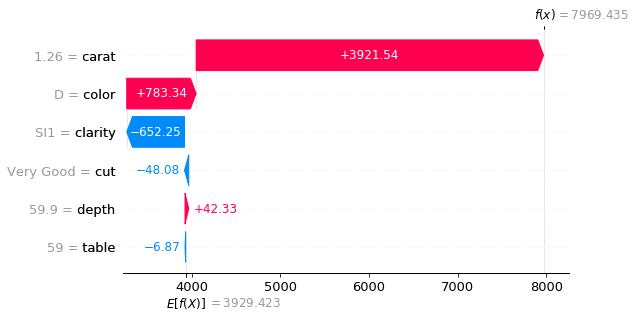

In [203]:
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[0], X_train.iloc[0,:])

Plot a summary plot

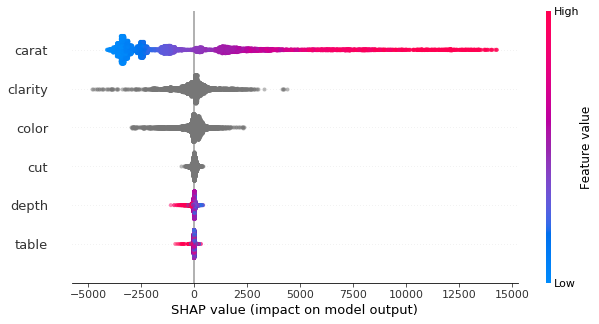

In [204]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2)

Plot dependency plots

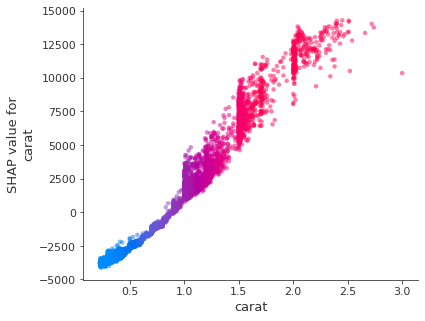

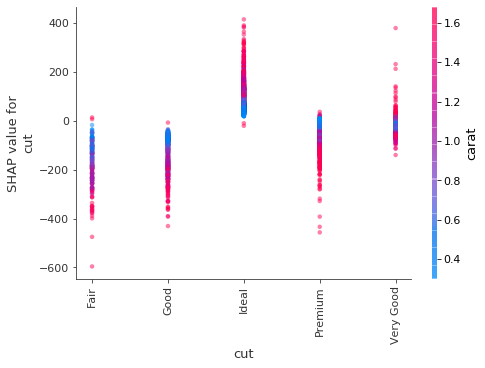

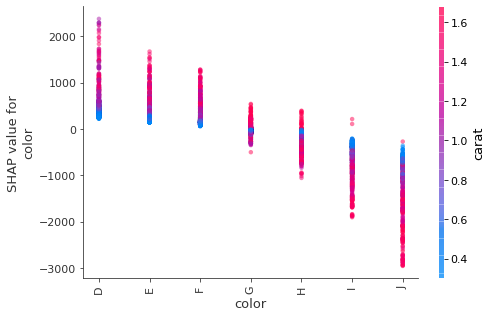

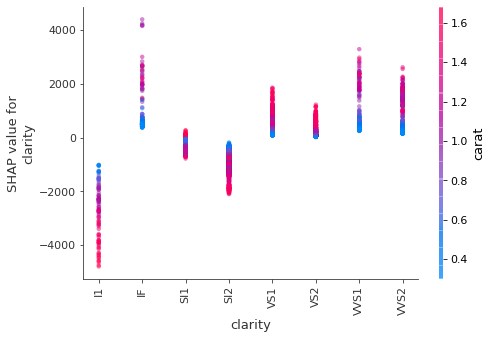

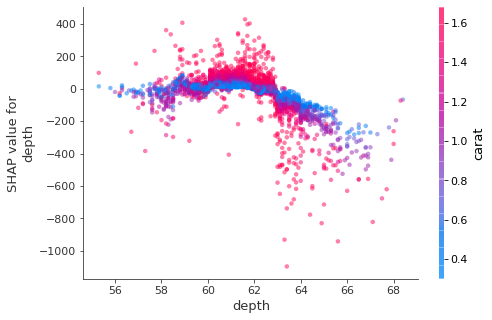

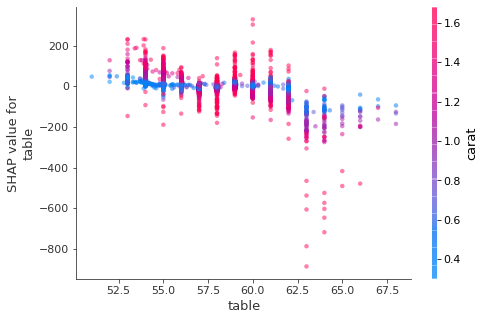

In [205]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'carat')

#### 3.3.3. Feature interactions

In [206]:
interactions = model.get_feature_importance(train_pool, type = 'Interaction', prettified = True)
mapper = dict(zip(np.linspace(0, len(X_train.columns) - 1, len(X_train.columns)).astype('int').tolist(), X_train.columns.tolist()))
interactions.replace({'First Feature Index' : mapper, 'Second Feature Index' : mapper}, inplace = True)

interactions

First Feature Index Second Feature Index  Interaction
0                carat              clarity    27.770802
1                carat                color    17.270239
2                color              clarity    10.010578
3                carat                depth     8.739790
4                carat                  cut     6.434591
5                carat                table     4.045323
6                  cut              clarity     3.807790
7                  cut                color     3.584576
8                color                depth     2.915203
9                  cut                depth     1.927854
10               depth                table     1.399510
11               color                table     1.373977
12             clarity                depth     1.353042
13             clarity                table     0.990500
14                 cut                table     0.649540

In [207]:
interactions_ = interactions.copy()
interactions_['First Feature Index'] = interactions['Second Feature Index']
interactions_['Second Feature Index'] = interactions['First Feature Index']

interactions_complete = pd.concat([interactions, interactions_])

In [208]:
interactions_complete = interactions_complete.pivot_table(index = 'First Feature Index', 
                                                          columns = 'Second Feature Index', 
                                                          values = 'Interaction', 
                                                          aggfunc = 'mean', fill_value = 0)

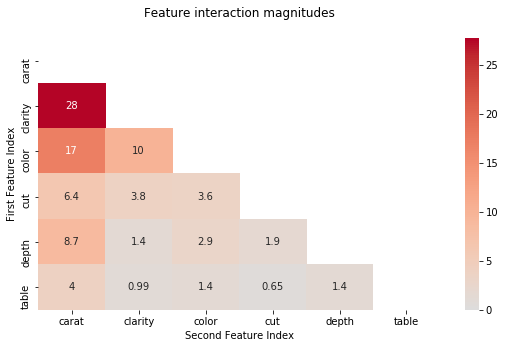

In [209]:
mask = np.triu(np.ones_like(interactions_complete, dtype = bool))

plt.figure(figsize = (9, 5))
sns.heatmap(interactions_complete, cmap = 'coolwarm', annot = True, center = 0, mask = mask)
plt.title('Feature interaction magnitudes\n')
plt.show()

### 3.4. Object importances

We can see which objects contributed to the increasing / decreasing of our error metric (RMSE)
- positive scores mean they increased RMSE
- negative scores mean they decreased RMSE

One can determine if they want to drop 'noisy' objects

In [210]:
indices, scores = model.get_object_importance(test_pool, train_pool, type = 'Average')

In [211]:
object_importances = pd.DataFrame({'train_index' : indices, 'contribution' : scores})
object_importances.sort_values('contribution', inplace = True)

In [212]:
object_importances

train_index  contribution
0          2826  -2004.208630
1           650  -1750.674053
2          2039  -1749.266627
3          4832  -1647.982530
7          7957  -1521.244882
..          ...           ...
10          828   1384.653397
8          4922   1429.484332
6          7543   1568.546105
5          1108   1592.279104
4          7323   1632.169060

[8000 rows x 2 columns]

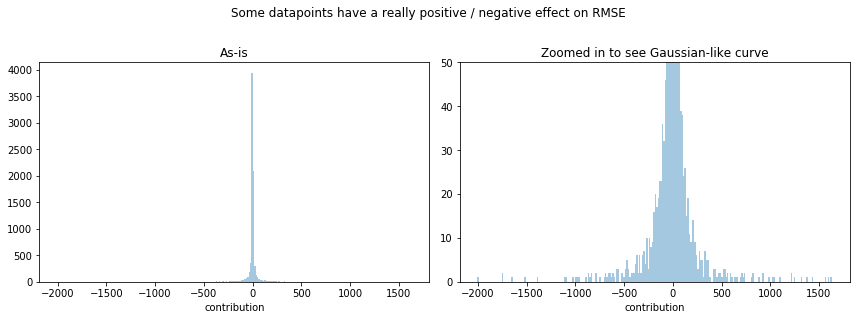

In [252]:
fig, ax = plt.subplots(figsize = (12, 5), ncols = 2)

sns.distplot(object_importances['contribution'], kde = False, bins = 250, ax = ax[0])
sns.distplot(object_importances['contribution'], kde = False, bins = 250, ax = ax[1])

plt.suptitle('Some datapoints have a really positive / negative effect on RMSE')
ax[0].set_title('As-is')
ax[1].set_title('Zoomed in to see Gaussian-like curve')
ax[1].set_ylim(0, 50)

plt.tight_layout(rect = [0, 0.1, 1, 0.9])
plt.show()

#### Which ones are these?

In [221]:
X_train.reset_index().merge(object_importances, left_on = 'index', right_on = 'train_index').sort_values('contribution')

index  carat        cut color clarity  depth  table  train_index  \
2826   2826   1.01    Premium     D      IF   61.6   56.0         2826   
650     650   2.22       Good     I     SI2   63.2   57.0          650   
2039   2039   2.02    Premium     F     SI2   61.7   58.0         2039   
4832   4832   1.50      Ideal     H    VVS2   61.3   56.0         4832   
7957   7957   2.00       Good     H     VS2   63.8   59.0         7957   
...     ...    ...        ...   ...     ...    ...    ...          ...   
828     828   1.80      Ideal     D     SI2   62.9   54.0          828   
4922   4922   2.02      Ideal     H     SI1   62.3   56.0         4922   
7543   7543   1.71       Good     F     SI2   63.7   54.0         7543   
1108   1108   2.10      Ideal     I     SI2   63.0   56.0         1108   
7323   7323   2.02  Very Good     G     SI2   63.3   57.0         7323   

      contribution  
2826  -2004.208630  
650   -1750.674053  
2039  -1749.266627  
4832  -1647.982530  
7957  -1521.244882  
...            ...  
828    1384.653397  
4922   1429.484332  
7543   1568.546105  
1108   1592.279104  
7323   1632.169060  

[8000 rows x 9 columns]